# Proyek Klasifikasi Gambar: Images Dataset
- **Nama:** Hilman Fauji Abdilah
- **Email:** accesinternethilmanfauzi@gmail.com
- **ID Dicoding:** hilmanfaujiabdilah

## Import Semua Packages/Library yang Digunakan

In [41]:
from google.colab import files
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
import numpy as np

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [1]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hilmanfaujiabdilah","key":"168864342ab69742a4deababc0f41e11"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Mengunduh dataset dari Kaggle menggunakan Kaggle API
!kaggle datasets download -d pavansanagapati/images-dataset

Dataset URL: https://www.kaggle.com/datasets/pavansanagapati/images-dataset
License(s): CC0-1.0


In [4]:
!unzip images-dataset.zip

Archive:  images-dataset.zip
  inflating: data/bike/bike_001.bmp  
  inflating: data/bike/bike_002.bmp  
  inflating: data/bike/bike_003.bmp  
  inflating: data/bike/bike_004.bmp  
  inflating: data/bike/bike_005.bmp  
  inflating: data/bike/bike_006.bmp  
  inflating: data/bike/bike_007.bmp  
  inflating: data/bike/bike_008.bmp  
  inflating: data/bike/bike_009.bmp  
  inflating: data/bike/bike_010.bmp  
  inflating: data/bike/bike_011.bmp  
  inflating: data/bike/bike_012.bmp  
  inflating: data/bike/bike_013.bmp  
  inflating: data/bike/bike_014.bmp  
  inflating: data/bike/bike_015.bmp  
  inflating: data/bike/bike_016.bmp  
  inflating: data/bike/bike_017.bmp  
  inflating: data/bike/bike_018.bmp  
  inflating: data/bike/bike_019.bmp  
  inflating: data/bike/bike_020.bmp  
  inflating: data/bike/bike_021.bmp  
  inflating: data/bike/bike_022.bmp  
  inflating: data/bike/bike_023.bmp  
  inflating: data/bike/bike_024.bmp  
  inflating: data/bike/bike_025.bmp  
  inflating: data/bik

### Data Preprocessing

#### Data Checking

In [14]:
dataset_dir = 'data/'
class_names = ['bike', 'cars', 'cats', 'flowers', 'dogs', 'horses', 'human']

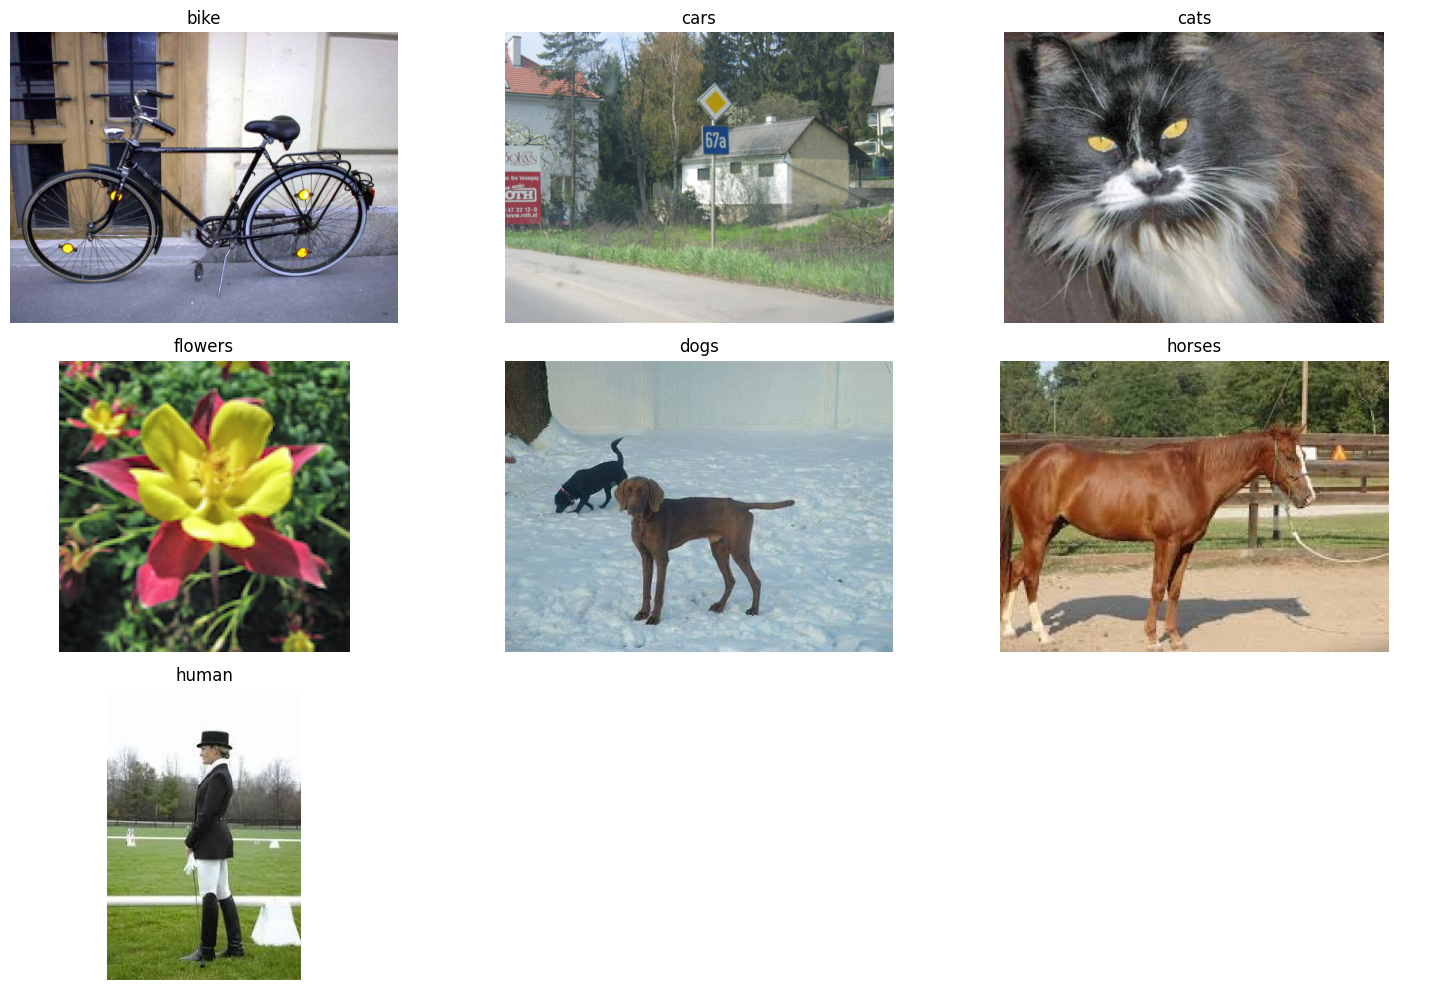

In [15]:
# Visualisasi gambar contoh dari setiap kelas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_folder)

    if not image_files:
        continue  # lewati jika folder kosong

    image_path = os.path.join(class_folder, image_files[0])
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(image_rgb)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')

# Sembunyikan subplot kosong jika jumlah kelas < jumlah grid
for i in range(len(class_names), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<ipython-input-16-14b5d31cddcb>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels, y=y_values, ax=ax, palette='Set3')


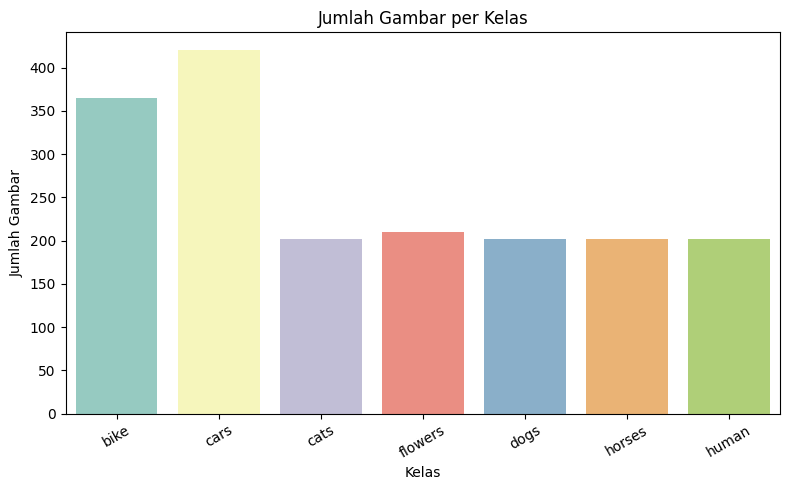

In [16]:
# Hitung jumlah gambar per kelas dari folder
image_counts = {}

for class_name in class_names:
    folder_path = os.path.join(dataset_dir, class_name)
    if os.path.exists(folder_path):
        num_images = len(os.listdir(folder_path))
        image_counts[class_name] = num_images
    else:
        image_counts[class_name] = 0

# Konversi ke list untuk plotting
x_labels = list(image_counts.keys())
y_values = list(image_counts.values())

# Visualisasi dalam bentuk bar chart
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=x_labels, y=y_values, ax=ax, palette='Set3')

# Pengaturan tampilan grafik
ax.set_title('Jumlah Gambar per Kelas')
ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Gambar')
ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

#### Split Dataset

In [18]:
# Folder output hasil split
output_dir = 'data_split'

# Rasio pembagian dataset
train_ratio = 0.7
val_ratio = 0.15  # sisa 15% akan otomatis untuk test

# Buat folder train, val, test beserta subfolder tiap kelas
for split_name in ['train', 'val', 'test']:
    split_path = os.path.join(output_dir, split_name)
    os.makedirs(split_path, exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(split_path, class_name), exist_ok=True)

# Proses pembagian data
for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_path)
    random.shuffle(image_files)

    total = len(image_files)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)

    train_images = image_files[:train_count]
    val_images = image_files[train_count:train_count + val_count]
    test_images = image_files[train_count + val_count:]

    # Salin ke folder train
    for image in train_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(output_dir, 'train', class_name, image)
        shutil.copy(src, dst)

    # Salin ke folder val
    for image in val_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(output_dir, 'val', class_name, image)
        shutil.copy(src, dst)

    # Salin ke folder test
    for image in test_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(output_dir, 'test', class_name, image)
        shutil.copy(src, dst)

print("Dataset berhasil dibagi ke dalam folder: train, val, dan test.")

Dataset berhasil dibagi ke dalam folder: train, val, dan test.


#### Data Augmentation

In [20]:
# Normalisasi dan augmentasi data untuk training
augmentation_config = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya normalisasi untuk val dan test
normalization_only = ImageDataGenerator(rescale=1.0 / 255)

In [21]:
# Path ke masing-masing folder split
train_path = os.path.join(output_dir, 'train')
val_path = os.path.join(output_dir, 'val')
test_path = os.path.join(output_dir, 'test')

In [22]:
# Generator untuk data training
train_loader = augmentation_config.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Generator untuk data validasi
val_loader = normalization_only.flow_from_directory(
    val_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Generator untuk data pengujian
test_loader = normalization_only.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1260 images belonging to 7 classes.
Found 268 images belonging to 7 classes.
Found 275 images belonging to 7 classes.


## Modelling

In [24]:
# Inisialisasi VGG16 tanpa top layer (fully connected)
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

# Freeze semua kecuali 4 layer terakhir
for layer in vgg_base.layers[:-4]:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [25]:
# Bangun model dengan menambahkan layer tambahan di atas VGG16
model = Sequential()
model.add(vgg_base)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_loader.num_classes, activation='softmax'))

In [26]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2, 2, 64)       │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,028,359 (57.33 MB)

 Trainable params: 7,392,967 (28.20 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [29]:
# Callback untuk menghentikan pelatihan lebih awal jika akurasi validasi tidak meningkat
callback_earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Callback untuk mengurangi learning rate jika validasi loss stagnan
callback_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

In [30]:
# Proses training model
training_history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=15,
    callbacks=[callback_earlystop, callback_reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 468s 12s/step - accuracy: 0.3205 - loss: 1.8294 - val_accuracy: 0.7799 - val_loss: 0.9479 - learning_rate: 1.0000e-04
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 479s 12s/step - accuracy: 0.6900 - loss: 0.9484 - val_accuracy: 0.8694 - val_loss: 0.5726 - learning_rate: 1.0000e-04
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 477s 12s/step - accuracy: 0.7878 - loss: 0.6991 - val_accuracy: 0.8507 - val_loss: 0.4858 - learning_rate: 1.0000e-04
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 477s 12s/step - accuracy: 0.8252 - loss: 0.5513 - val_accuracy: 0.8955 - val_loss: 0.3295 - learning_rate: 1.0000e-04
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 459s 12s/step - accuracy: 0.8818 - loss: 0.4276 - val_accuracy: 0.9030 - val_loss: 0.3100 - learning_rate: 1.0000e-04
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 515s 12s/step - accuracy: 0.9062 - loss: 0.3401 - val_accuracy: 0.9403 - val_loss: 0.2282 - learning_rate: 1.0000e-04
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 472s 12s/step - accuracy: 

## Evaluasi dan Visualisasi

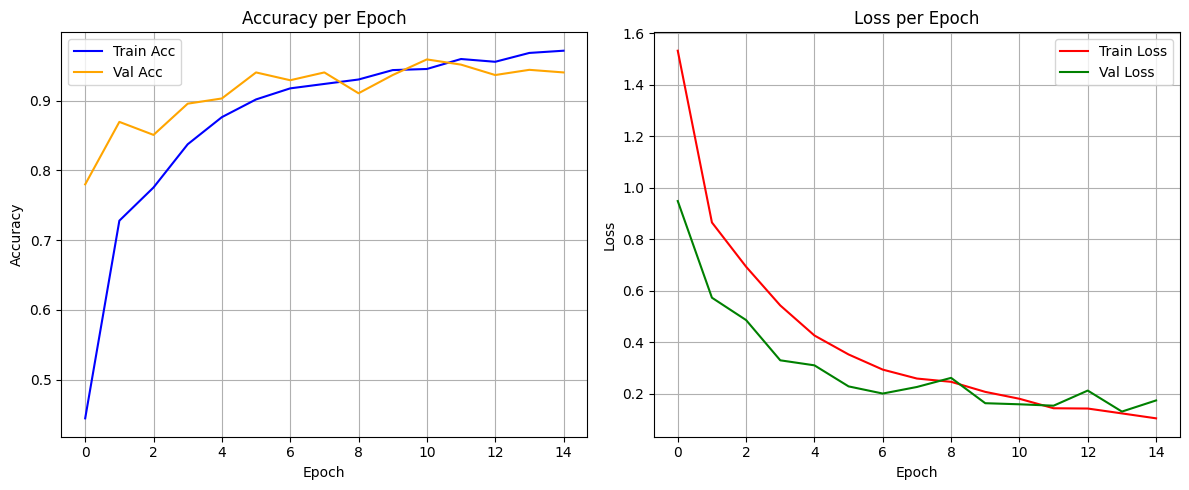

In [31]:
# Visualisasi performa model selama pelatihan
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot akurasi
axes[0].plot(training_history.history['accuracy'], label='Train Acc', color='blue')
axes[0].plot(training_history.history['val_accuracy'], label='Val Acc', color='orange')
axes[0].set_title('Accuracy per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(training_history.history['loss'], label='Train Loss', color='red')
axes[1].plot(training_history.history['val_loss'], label='Val Loss', color='green')
axes[1].set_title('Loss per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Konversi Model

In [32]:
# Direktori penyimpanan model
export_dir = 'saved_model_format'
os.makedirs(export_dir, exist_ok=True)

# Simpan model dalam format SavedModel
tf.saved_model.save(model, export_dir)

In [33]:
# Konversi ke TFLite
lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model = lite_converter.convert()

# Simpan model TFLite
lite_dir = 'lite_model_output'
os.makedirs(lite_dir, exist_ok=True)

lite_path = os.path.join(lite_dir, 'model_converted.tflite')
with open(lite_path, 'wb') as file:
    file.write(lite_model)

Saved artifact at '/tmp/tmpi8iisd2m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134750984939536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134749466967312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134747983895760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134747983894800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134747983895568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134747983891152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134747983895376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134747983894992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134747983896912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134747983897872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13474798389

In [34]:
# Simpan ke dalam format HDF5 (.h5)
model.save('final_model.h5')

In [35]:
# TensorFlow.js conversion
# Install dependensi
!pip install tensorflowjs

# Konversi H5 ke TensorFlow.js format
!tensorflowjs_converter --input_format=keras final_model.h5 tfjs_output_dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-05 13:19:54.360975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746451194.398073   36438 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [36]:
# Simpan daftar dependensi
!pip freeze > requirements.txt

In [51]:
shutil.make_archive('tfjs_output_dir', 'zip', 'tfjs_output_dir')

'/content/tfjs_output_dir.zip'

In [52]:
files.download('tfjs_output_dir.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [53]:
# Path ke gambar untuk inferensi
image_path = 'cat.100.jpg'

# Preprocessing gambar (ukuran harus sesuai input model: 150x150)
img = cv2.imread(image_path)
img = cv2.resize(img, (150, 150))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_image = np.expand_dims(img / 255.0, axis=0)  # normalisasi dan tambah batch dim

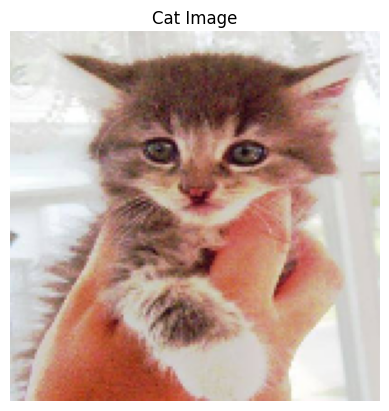

In [56]:
# Tampilkan gambar yang sudah di-convert ke RGB
plt.imshow(img)
plt.title("Cat Image")
plt.axis('off')  # hilangkan sumbu
plt.show()

In [55]:
# Load model HDF5
h5_model = tf.keras.models.load_model('final_model.h5')

# Prediksi
prediction = h5_model.predict(input_image)
predicted_class = np.argmax(prediction)
print("Predicted class index (H5):", class_names[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
Predicted class index (H5): cats
